# 1. Data Preparation

### Import libraries

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
import timeit
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.utils.class_weight import compute_class_weight
from sklearn import metrics
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def get_classes(data_path, classes, data):
    print(f"---- {data} ----")
    knee_severity = {}
    count = 0

    for i in range(len(classes)):
        imgs = os.listdir(os.path.join(data_path, str(i)))
        knee_severity[i] = imgs
        count += len(imgs)

    for k, v in knee_severity.items():
        print(
            f"Grade {k} - {classes[k]}: {len(v)} images, {round((len(v) * 100) / count, 2)}%"
        )

    return knee_severity


def plot_classes(dict_classes, data_path, classes, data):
    for k, v in dict_classes.items():
        print(f"{data} - {classes[k]}")
        plt.figure(figsize=(10, 25))
        for i in range(5):
            img_path = os.path.join(data_path, str(k), v[i])
            img = tf.keras.preprocessing.image.load_img(img_path)
            plt.subplot(1, 5, 1 + i, xticks=[], yticks=[])
            plt.imshow(img)
            plt.title(f"Grade {k}")
        plt.show()

## Load data

In [ ]:
class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

In [ ]:
base_dir = r"/content/drive/MyDrive/dataset"
train_path = os.path.join(base_dir, 'train')
valid_path = os.path.join(base_dir, 'val')
test_path = os.path.join(base_dir, 'test')


In [ ]:
train_data = get_classes(train_path, class_names, 'Train')
valid_data = get_classes(valid_path, class_names, 'Valid')
tests_data = get_classes(test_path, class_names, 'Test')

---- Train ----
Grade 0 - Healthy: 2286 images, 39.56%
Grade 1 - Doubtful: 1046 images, 18.1%
Grade 2 - Minimal: 1516 images, 26.24%
Grade 3 - Moderate: 757 images, 13.1%
Grade 4 - Severe: 173 images, 2.99%
---- Valid ----
Grade 0 - Healthy: 328 images, 39.71%
Grade 1 - Doubtful: 153 images, 18.52%
Grade 2 - Minimal: 212 images, 25.67%
Grade 3 - Moderate: 106 images, 12.83%
Grade 4 - Severe: 27 images, 3.27%
---- Test ----
Grade 0 - Healthy: 639 images, 38.59%
Grade 1 - Doubtful: 296 images, 17.87%
Grade 2 - Minimal: 447 images, 26.99%
Grade 3 - Moderate: 223 images, 13.47%
Grade 4 - Severe: 51 images, 3.08%


## Visualize data

### Train data

Train data - Healthy


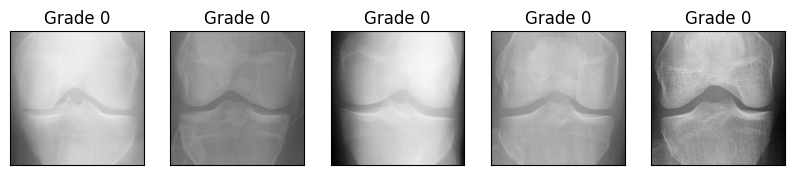

Train data - Doubtful


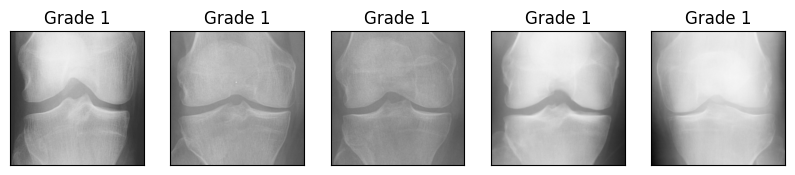

Train data - Minimal


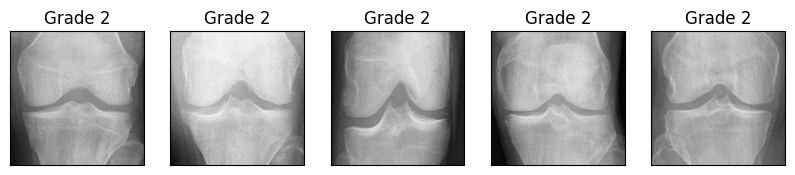

Train data - Moderate


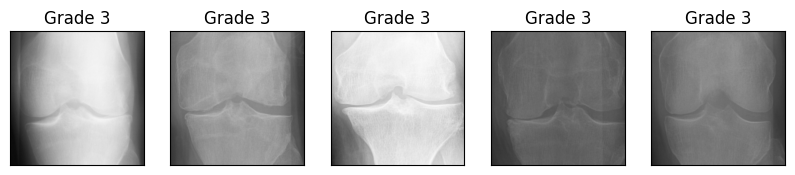

Train data - Severe


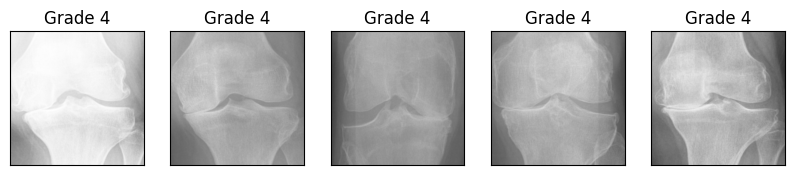

In [ ]:
plot_classes(train_data, train_path, class_names, 'Train data')

### Valid data

Valid data - Healthy


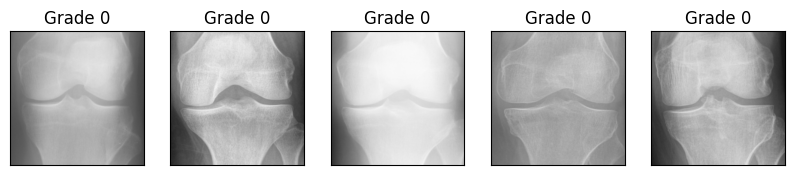

Valid data - Doubtful


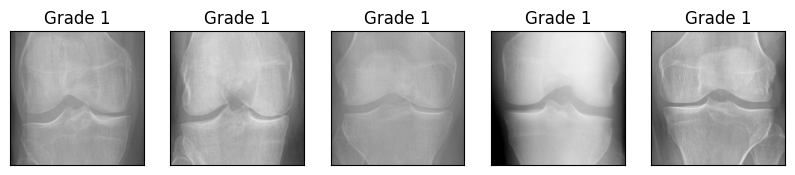

Valid data - Minimal


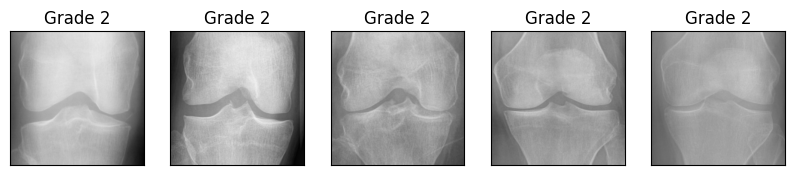

Valid data - Moderate


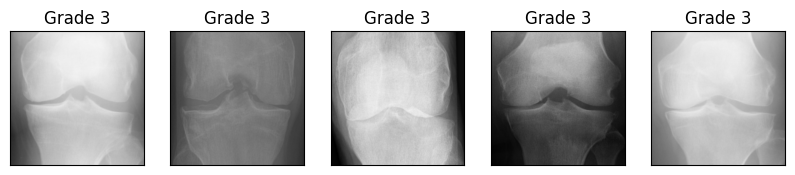

Valid data - Severe


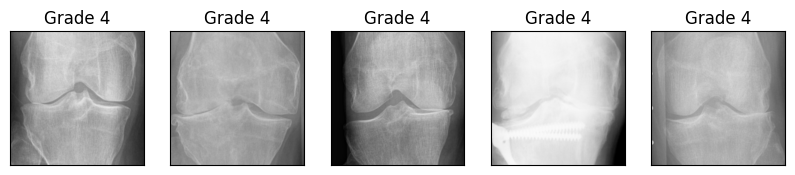

In [ ]:
plot_classes(valid_data, valid_path, class_names, 'Valid data')

### Test data

Test data - Healthy


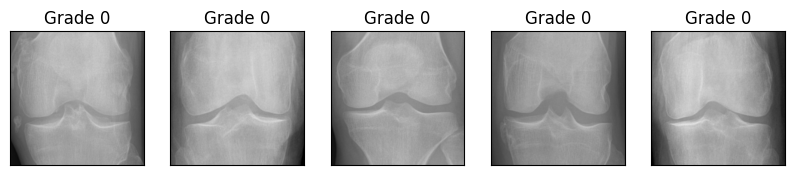

Test data - Doubtful


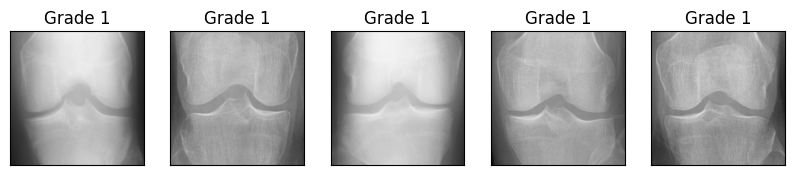

Test data - Minimal


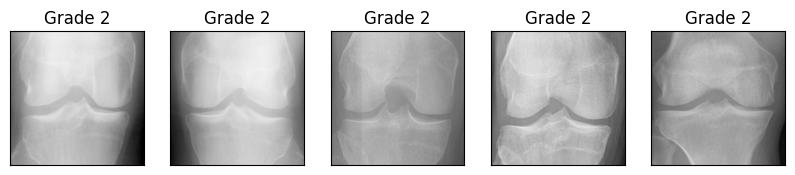

Test data - Moderate


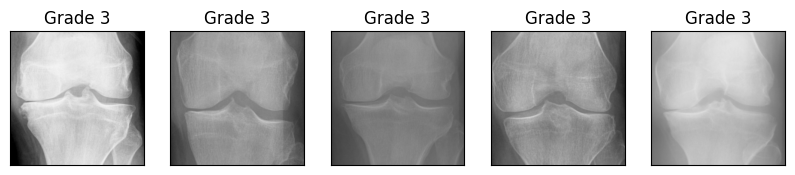

Test data - Severe


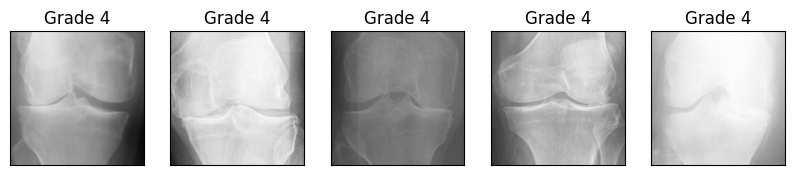

In [ ]:
plot_classes(tests_data, test_path, class_names, 'Test data')

## Image Data Generator Examples

#### brightness_range

Found 5778 images belonging to 5 classes.


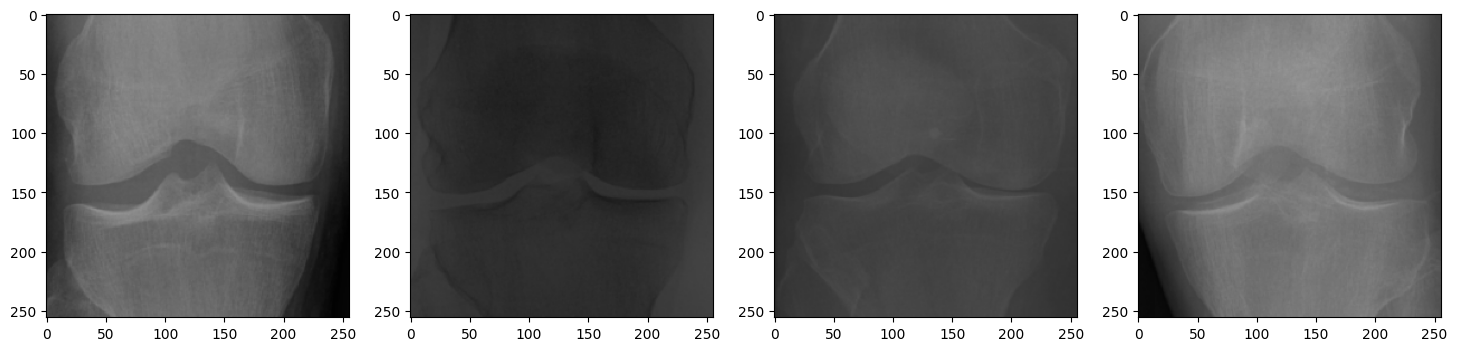

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    brightness_range=[0.3, 0.8]
)
imagegen = datagen.flow_from_directory(train_path, batch_size=1)
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18, 18))
for row in rows:
    row.imshow(imagegen.next()[0][0].astype("uint8"))
plt.show()

#### width_shift_range

Found 5778 images belonging to 5 classes.


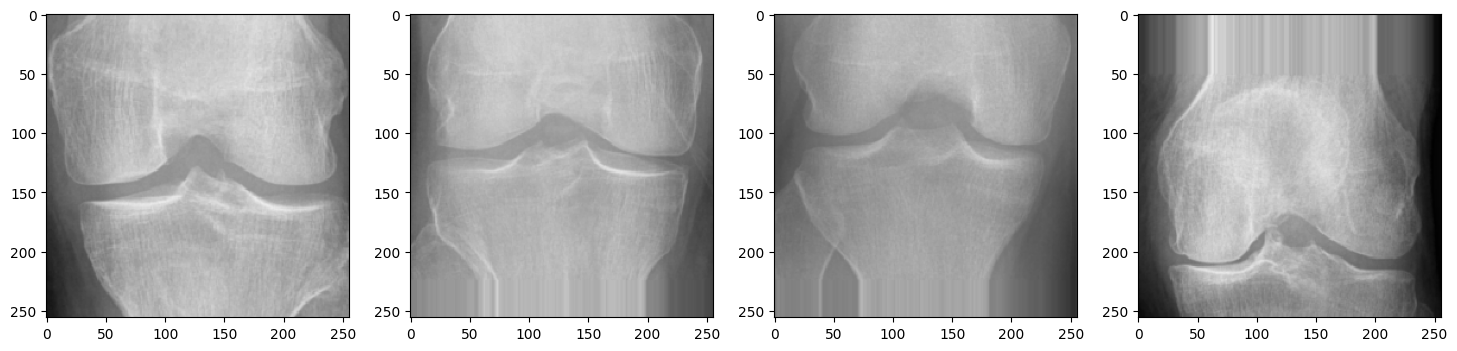

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    width_shift_range=[-50,0,50,30,-30]
)
imagegen = datagen.flow_from_directory(train_path, batch_size=5)
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18,18))
for row in rows:
    row.imshow(imagegen.next()[0][0].astype('uint8'))
plt.show()

#### zoom_range

Found 5778 images belonging to 5 classes.


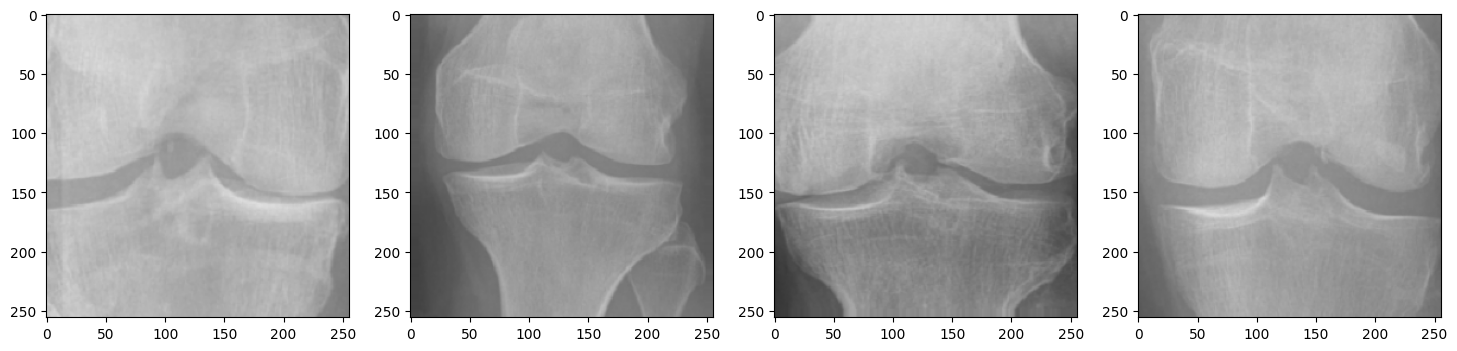

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    zoom_range=0.2
)
imagegen = datagen.flow_from_directory(train_path, batch_size=1)
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18,18))
for row in rows:
    row.imshow(imagegen.next()[0][0].astype('uint8'))
plt.show()

#### horizontal_flip

Found 5778 images belonging to 5 classes.


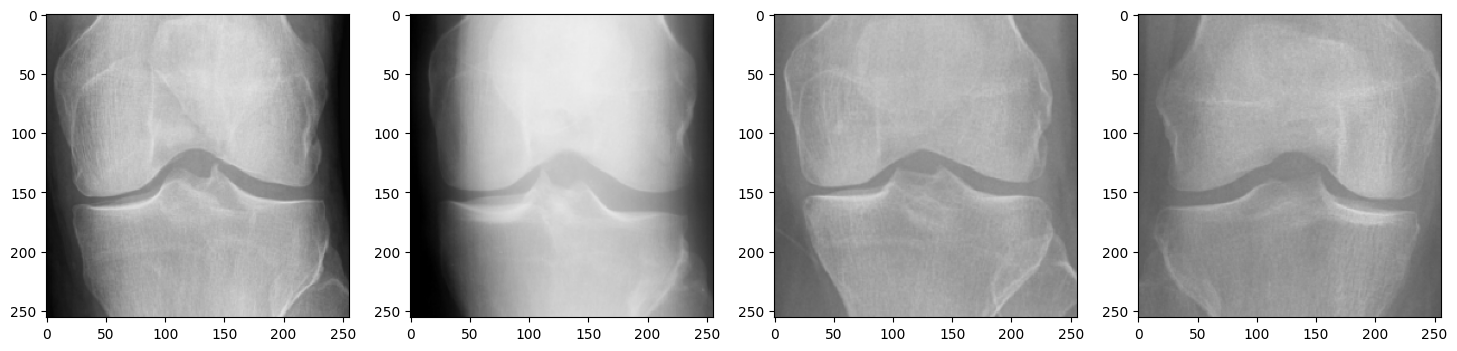

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True
)
imagegen = datagen.flow_from_directory(train_path, batch_size=1)
fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18,18))
for row in rows:
    row.imshow(imagegen.next()[0][0].astype('uint8'))
plt.show()

## Image Data Generator and Preprocess

In [ ]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.EfficientNetB0.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.EfficientNetB0.preprocess_input,
)

In [ ]:
target_size = (224, 224)

train_generator = aug_datagen.flow_from_directory(
    train_path, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 5778 images belonging to 5 classes.
Found 826 images belonging to 5 classes.


In [ ]:
train_generator[0][0].shape

(32, 224, 224, 3)

In [ ]:
y_train = train_generator.labels
y_val = valid_generator.labels

In [ ]:
def get_plot_loss_acc(model, model_name):
    fig = plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n\n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="lower right")

    plt.tight_layout()

MODEL BUILDING

In [ ]:
model1_name = "EffNetB5"
class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

target_size = (224, 224)
epochs = 50
batch_size = 256
img_shape = (224, 224, 3)


save_model = os.path.join('models', f'model_{model1_name}_ft.hdf5')

In [ ]:
model1 = tf.keras.applications.EfficientNetB5(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

In [ ]:
for layer in model1.layers:
    layer.trainable = True

model_1 = tf.keras.models.Sequential(
    [
        model1,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation="softmax"),
    ]
)


In [ ]:
model_1.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

start = timeit.default_timer()

history = model_1.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early],
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop = timeit.default_timer()

Epoch 1/50
181/181 [==============================] - 147s 608ms/step - loss: 2.0324 - accuracy: 0.1911 - val_loss: 1756337.2500 - val_accuracy: 0.1283
Epoch 2/50
181/181 [==============================] - 109s 604ms/step - loss: 1.8697 - accuracy: 0.0407 - val_loss: 5.3593 - val_accuracy: 0.1780
Epoch 3/50
181/181 [==============================] - 110s 608ms/step - loss: 1.7137 - accuracy: 0.0421 - val_loss: 94.9369 - val_accuracy: 0.0605
Epoch 4/50
181/181 [==============================] - 109s 602ms/step - loss: 1.7136 - accuracy: 0.1141 - val_loss: 1.5782 - val_accuracy: 0.1199
Epoch 5/50
181/181 [==============================] - 110s 607ms/step - loss: 1.6425 - accuracy: 0.1829 - val_loss: 1.6979 - val_accuracy: 0.2893
Epoch 6/50
181/181 [==============================] - 109s 602ms/step - loss: 1.6751 - accuracy: 0.1746 - val_loss: 1.6319 - val_accuracy: 0.1259
Epoch 7/50
181/181 [==============================] - 109s 603ms/step - loss: 1.6462 - accuracy: 0.1809 - val_loss: 1

In [ ]:
model_1.save(save_model)

In [ ]:
execution_time_ft = (stop - start) / 60
print(
    f"Model {model1_name} fine tuning executed in {execution_time_ft:.2f} minutes"
)

Model EffNetB5 fine tuning executed in 24.86 minutes


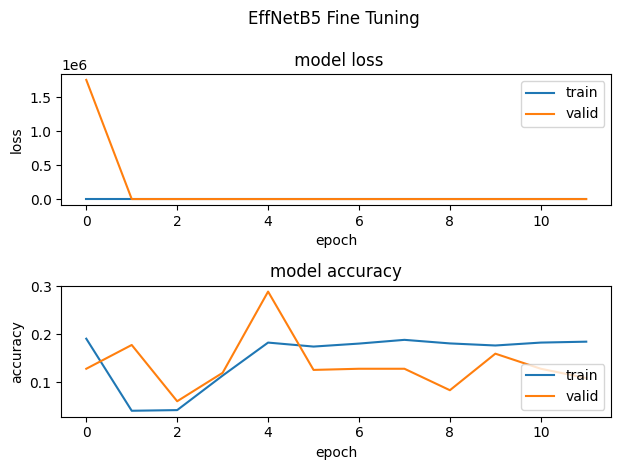

In [ ]:
get_plot_loss_acc(model_1, f"{model1_name} Fine Tuning")

MODEL 2


In [ ]:
model2_name = "EffNetB0"
class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

target_size = (224, 224)
epochs = 50
batch_size = 256
img_shape = (224, 224, 3)

# Save model
save_model2 = os.path.join('models', f'model_{model2_name}_ft.hdf5')

In [ ]:
model2 = tf.keras.applications.EfficientNetB0(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

In [ ]:
for layer in model2.layers:
    layer.trainable = True

model_2 = tf.keras.models.Sequential(
    [
        model2,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation="softmax"),
    ]
)



In [ ]:
model_2.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

start_2 = timeit.default_timer()

history = model_2.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early],
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop_2 = timeit.default_timer()

Epoch 1/50
181/181 [==============================] - 163s 710ms/step - loss: 1.2398 - accuracy: 0.4027 - val_loss: 3.0849 - val_accuracy: 0.4528
Epoch 2/50
181/181 [==============================] - 123s 680ms/step - loss: 0.9625 - accuracy: 0.5035 - val_loss: 4.9425 - val_accuracy: 0.4080
Epoch 3/50
181/181 [==============================] - 123s 678ms/step - loss: 0.9183 - accuracy: 0.5412 - val_loss: 1.3582 - val_accuracy: 0.4600
Epoch 4/50
181/181 [==============================] - 124s 682ms/step - loss: 0.8246 - accuracy: 0.5789 - val_loss: 1.1541 - val_accuracy: 0.5206
Epoch 5/50
181/181 [==============================] - 123s 676ms/step - loss: 0.7746 - accuracy: 0.5948 - val_loss: 1.3997 - val_accuracy: 0.5266
Epoch 6/50
181/181 [==============================] - 123s 675ms/step - loss: 0.7580 - accuracy: 0.6090 - val_loss: 1.1940 - val_accuracy: 0.4806
Epoch 7/50
181/181 [==============================] - 122s 675ms/step - loss: 0.7071 - accuracy: 0.6281 - val_loss: 1.4495 -

In [ ]:
execution_time_ft = (stop_2 - start_2) / 60
print(
    f"Model {model2_name} fine tuning executed in {execution_time_ft:.2f} minutes"
)

Model EffNetB0 fine tuning executed in 36.77 minutes


In [ ]:
model_2.save(save_model2)

In [ ]:
model.load(model_EffNetB0)

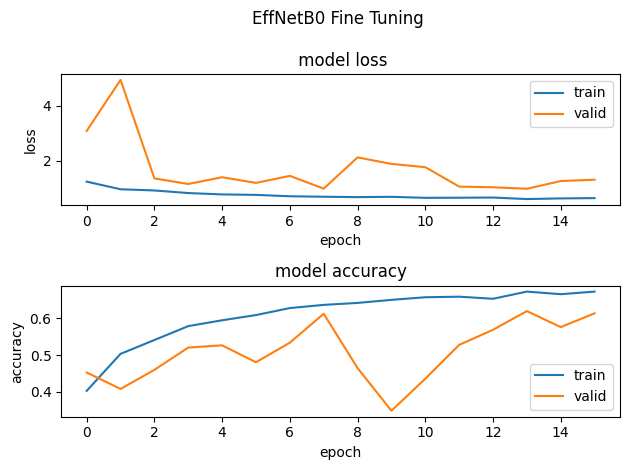

In [ ]:
get_plot_loss_acc(model_2, f"{model2_name} Fine Tuning")

MODEL 3

In [ ]:
model3_name = "EffNetb7"
class_names = ['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

target_size = (224, 224)
epochs = 50
batch_size = 256
img_shape = (224, 224, 3)

save_model3 = os.path.join('models', f'model_{model3_name}_ft.hdf5')


In [ ]:
model3 = tf.keras.applications.EfficientNetB7(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

In [ ]:
for layer in model3.layers:
    layer.trainable = True

model_3 = tf.keras.models.Sequential(
    [
        model3,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation="softmax"),
    ]
)


In [ ]:
model_3.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

start_3 = timeit.default_timer()

history = model_3.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early],
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop_3 = timeit.default_timer()

Epoch 1/50
181/181 [==============================] - 243s 764ms/step - loss: 1.2389 - accuracy: 0.3960 - val_loss: 1.3500 - val_accuracy: 0.4080
Epoch 2/50
181/181 [==============================] - 126s 696ms/step - loss: 0.9507 - accuracy: 0.5197 - val_loss: 1.5019 - val_accuracy: 0.4915
Epoch 3/50
181/181 [==============================] - 126s 696ms/step - loss: 0.8976 - accuracy: 0.5478 - val_loss: 3.0190 - val_accuracy: 0.4237
Epoch 4/50
181/181 [==============================] - 126s 695ms/step - loss: 0.8501 - accuracy: 0.5758 - val_loss: 1.1092 - val_accuracy: 0.4903
Epoch 5/50
181/181 [==============================] - 127s 699ms/step - loss: 0.8046 - accuracy: 0.5917 - val_loss: 2.8633 - val_accuracy: 0.5109
Epoch 6/50
181/181 [==============================] - 126s 693ms/step - loss: 0.7587 - accuracy: 0.6057 - val_loss: 1.1796 - val_accuracy: 0.4903
Epoch 7/50
181/181 [==============================] - 125s 687ms/step - loss: 0.7342 - accuracy: 0.6265 - val_loss: 1.1506 -

In [ ]:
execution_time_ft = (stop_3 - start_3) / 60
print(
    f"Model {model3_name} fine tuning executed in {execution_time_ft:.2f} minutes"
)

Model EffNetb7 fine tuning executed in 70.35 minutes


In [ ]:
model_3.save(save_model3)

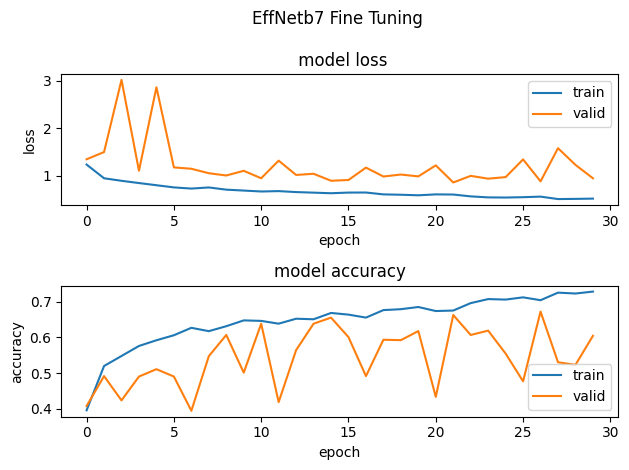

In [ ]:
get_plot_loss_acc(model_3, f"{model3_name} Fine Tuning")

COMPARISON


| Model                        | Accuracy          | Time Execution |
| ---------------------------- | ----------------- | -------------- |
| EfficientNetB0               | 61%               | 37min          |
| EfficientNetB5               | 10%               | 25min          |
| EfficientNetB7               | 60%               | 71min          |



TESTING

In [ ]:
model_name = "EfficientNetB0"
batch_size = 256
target_size = (224, 224)

In [ ]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.EfficientNetB0.preprocess_input
)


In [ ]:
test_generator = noaug_datagen.flow_from_directory(
    test_path,
    batch_size=batch_size,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 1656 images belonging to 5 classes.


In [ ]:
y_test = test_generator.labels

In [ ]:
EffNetB0 = tf.keras.models.load_model('/content/models/model_EffNetB0_ft.hdf5')

In [ ]:
predictions_EffNetB0 = EffNetB0.predict(test_generator)
score_EffNetB0 = EffNetB0.evaluate(test_generator, verbose=1)
print('Test loss:', score_EffNetB0[0])
print('Test acc:', score_EffNetB0[1])

7/7 [==============================] - 9s 1s/step - loss: 7.0567 - accuracy: 0.3859
Test loss: 7.056702136993408
Test acc: 0.685869562625885


In [ ]:
image = cv2.imread('/content/drive/MyDrive/dataset/test/2/9011053R.png')

Prdeiction : Grading 2 - Minimal


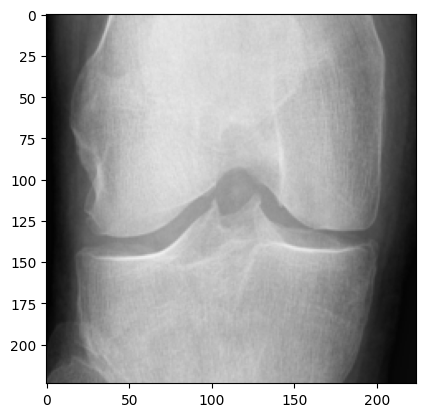

In [ ]:
pred=model.predict(image)
print(pred)